In [92]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [93]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-12,20628.029297,22185.031250,20448.806641,22163.949219,29279035521
2023-03-13,22156.406250,24550.837891,21918.199219,24197.533203,49466362688
2023-03-14,24201.765625,26514.716797,24081.183594,24746.074219,54622230164
2023-03-15,24770.925781,25240.615234,23964.910156,24375.960938,43655701450
2023-03-16,24373.457031,25190.326172,24225.111328,25052.789063,33866061747


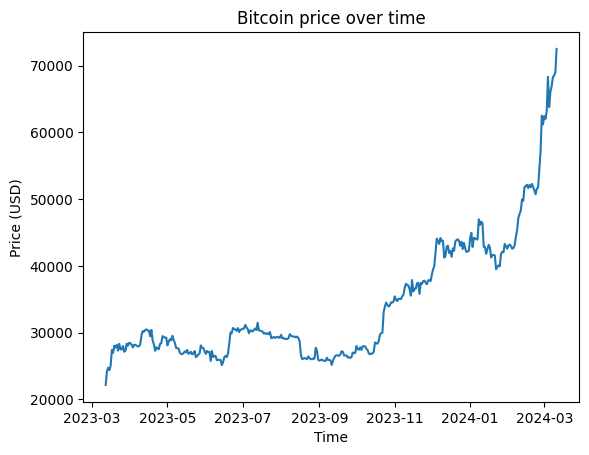

In [94]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [95]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((366, 4), (366,))

In [96]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [97]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(218, 100, 4) (218, 50)


In [98]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
y_mm[0]

array([0.09308946, 0.12241321, 0.15617288, 0.15388857, 0.16944335,
       0.1665283 , 0.16516915, 0.16101563, 0.16929827, 0.15734366,
       0.1644758 , 0.16510937, 0.1673502 , 0.16795976, 0.17859862,
       0.17107419, 0.16584252, 0.15383011, 0.16242843, 0.16144085,
       0.1590316 , 0.16386248, 0.16796336, 0.16340917, 0.18494634,
       0.16226562, 0.16150571, 0.16057873, 0.15852821, 0.15278194,
       0.15392119, 0.15149999, 0.15381832, 0.15109854, 0.15730976,
       0.13928358, 0.14028605, 0.14281994, 0.13995435, 0.14211038,
       0.14285857, 0.14123774, 0.14034008, 0.1491905 , 0.13878791,
       0.13931861, 0.1372414 , 0.13660655, 0.13660116, 0.13935631])

In [99]:
y_trans[99:149].squeeze(1)

array([0.09308946, 0.12241321, 0.15617288, 0.15388857, 0.16944335,
       0.1665283 , 0.16516915, 0.16101563, 0.16929827, 0.15734366,
       0.1644758 , 0.16510937, 0.1673502 , 0.16795976, 0.17859862,
       0.17107419, 0.16584252, 0.15383011, 0.16242843, 0.16144085,
       0.1590316 , 0.16386248, 0.16796336, 0.16340917, 0.18494634,
       0.16226562, 0.16150571, 0.16057873, 0.15852821, 0.15278194,
       0.15392119, 0.15149999, 0.15381832, 0.15109854, 0.15730976,
       0.13928358, 0.14028605, 0.14281994, 0.13995435, 0.14211038,
       0.14285857, 0.14123774, 0.14034008, 0.1491905 , 0.13878791,
       0.13931861, 0.1372414 , 0.13660655, 0.13660116, 0.13935631])

In [100]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (68, 100, 4) (68, 50)
Testing Shape: (150, 100, 4) (150, 50)


In [101]:
# # convert to pytorch tensors
# X_train_tensors = torch.tensor(X_train)
# X_test_tensors = torch.tensor(X_test)
# y_train_tensors = torch.tensor(y_train)
# y_test_tensors = torch.tensor(y_test)

In [102]:
# # reshaping to rows, timestamps, features
# X_train_tensors_final = torch.reshape(X_train_tensors,   
#                                       (X_train_tensors.shape[0], 100, 
#                                        X_train_tensors.shape[2]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  
#                                      (X_test_tensors.shape[0], 100, 
#                                       X_test_tensors.shape[2])) 
# convert to pytorch tensors
X_train_tensors_final = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors_final = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

# reshaping to batch_size, seq_len, input_size
X_train_tensors_final = X_train_tensors_final.view(-1, 100, 4)
X_test_tensors_final = X_test_tensors_final.view(-1, 100, 4)

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([68, 100, 4]) torch.Size([68, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [103]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[2.68580117e+04, 2.72891699e+04, 2.68178945e+04, 7.09820198e+09],
       [2.71626289e+04, 2.94481387e+04, 2.71304727e+04, 2.78338765e+10],
       [2.85220977e+04, 2.86187520e+04, 2.81101855e+04, 1.48725275e+10],
       [2.84135312e+04, 2.88890098e+04, 2.81742520e+04, 1.27241286e+10]])

In [104]:
X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2023-10-15,26858.011719,27289.169922,26817.894531,7098201980
2023-10-16,27162.628906,29448.138672,27130.472656,27833876539
2023-10-17,28522.097656,28618.751953,28110.185547,14872527508
2023-10-18,28413.531250,28889.009766,28174.251953,12724128586


In [105]:
y_check[-1]

array([39507.367188, 39845.550781, 40077.074219, 39933.808594,
       41816.871094, 42120.054688, 42035.59375 , 43288.246094,
       42952.609375, 42582.605469, 43075.773438, 43185.859375,
       42992.25    , 42583.582031, 42658.667969, 43084.671875,
       44318.222656, 45301.566406, 47147.199219, 47771.277344,
       48293.917969, 49958.222656, 49742.441406, 51826.695313,
       51938.554688, 52160.203125, 51662.996094, 52122.546875,
       51779.144531, 52284.875   , 51839.179688, 51304.972656,
       50731.949219, 51571.101563, 51733.238281, 54522.402344,
       57085.371094, 62504.789063, 61198.382813, 62440.632813,
       62029.847656, 63167.371094, 68330.414063, 63801.199219,
       66106.804688, 66925.484375, 68300.09375 , 68498.882813,
       69019.789063, 72514.226563])

In [106]:
df.Close.values[-50:]

array([39507.367188, 39845.550781, 40077.074219, 39933.808594,
       41816.871094, 42120.054688, 42035.59375 , 43288.246094,
       42952.609375, 42582.605469, 43075.773438, 43185.859375,
       42992.25    , 42583.582031, 42658.667969, 43084.671875,
       44318.222656, 45301.566406, 47147.199219, 47771.277344,
       48293.917969, 49958.222656, 49742.441406, 51826.695313,
       51938.554688, 52160.203125, 51662.996094, 52122.546875,
       51779.144531, 52284.875   , 51839.179688, 51304.972656,
       50731.949219, 51571.101563, 51733.238281, 54522.402344,
       57085.371094, 62504.789063, 61198.382813, 62440.632813,
       62029.847656, 63167.371094, 68330.414063, 63801.199219,
       66106.804688, 66925.484375, 68300.09375 , 68498.882813,
       69019.789063, 72514.226563])

In [107]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [108]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [109]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [110]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [111]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.05140, test loss: 0.15814
Epoch: 100, train loss: 0.00083, test loss: 0.06048
Epoch: 200, train loss: 0.00064, test loss: 0.05416
Epoch: 300, train loss: 0.00043, test loss: 0.04906
Epoch: 400, train loss: 0.00033, test loss: 0.04707
Epoch: 500, train loss: 0.00030, test loss: 0.04609
Epoch: 600, train loss: 0.00026, test loss: 0.04435
Epoch: 700, train loss: 0.00022, test loss: 0.04375
Epoch: 800, train loss: 0.00019, test loss: 0.04523
Epoch: 900, train loss: 0.00016, test loss: 0.04582


Current shape of input data: (218, 100, 4)


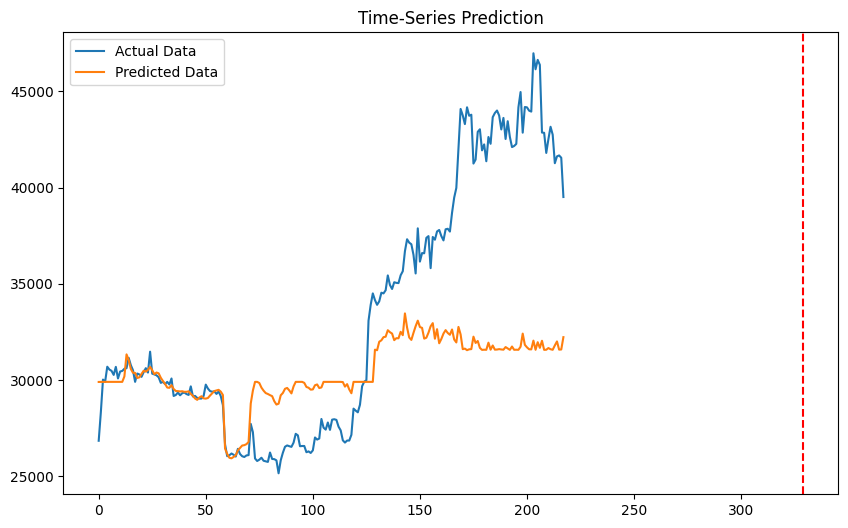

In [122]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# Print the current shape of input data
print("Current shape of input data:", df_X_ss.shape)

# Adjust the reshaping if the shape doesn't match the expected size
expected_shape = (df_X_ss.shape[0], 100, df_X_ss.shape[2])
if df_X_ss.shape != expected_shape:
    df_X_ss = df_X_ss.reshape(expected_shape)

# converting to tensors
df_X_ss = torch.tensor(df_X_ss, dtype=torch.float32)
df_y_mm = torch.tensor(df_y_mm, dtype=torch.float32)

# forward pass through LSTM
train_predict = lstm(df_X_ss)
data_predict = mm.inverse_transform(train_predict.squeeze().detach().numpy())
dataY_plot = mm.inverse_transform(df_y_mm.numpy())

true = dataY_plot[:, 0]
preds = data_predict[:, 0]

plt.figure(figsize=(10, 6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()